### Introduction to Machine Learning
Jaeden Bardati 2025

This jupyter notebook gives you a brief survey of some of the basic tools used in machine learning. It gives a "breadth-first" approach where I focus on giving a shallow but broad introduction to applied machine learning (ML) to familiarize you with the possible tools. The focus is on to get you working hands-on as soon as possible (there's mathematical rigor to most of this, but when applying you mostly only need to know the basics). Generally, this is meant to serve as a jumping off point whereupon you can go and investigate specifics in more depth as you need (google is great for this, and there are tons of tutorials out there on everything and much more than is covered here, e.g. transformers and LLMs, reinforcement learning, etc.). That said, I do not go into how anything works in this notebook, so just look it up as you find terms you aren't familiar with or read a review before (e.g. https://arxiv.org/abs/1904.07248).

Most machine learning tends to be done in Python and presumes familiarity with packages like numpy, matplotlib, pandas, scipy, etc. When you are applying ML, you don't need to re-invent the wheel and there are dedicated packages for most things that you will use: e.g. scikit-learn (for simple ML), tensorflow or pytorch (for deep learning). It may be worth noting that there also exist Bayesian statistics and MCMC packages like PyMC, which are often useful for data analysis which can often mix with ML, but that's not covered here. The choice between tensorflow and pytorch comes mostly down to preference, but I like using the keras API in tensorflow for quickly building a simple model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn                   # scikit-learn is accessed through "sklearn" 
import tensorflow as tf
from tensorflow import keras

#### Supervised Learning - Classifier

The quintessential example of machine learning is a classifier. The goal is to have your model pick out the correct class that each data point belongs to. The example we will do here is to get a model to determine the numbers associated to images of handwritten numbers. The following code just loads in some image data, which you can get from https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download.

##### Getting Data

In [2]:
# big block of code to load the MNIST dataset from kaggle (https://www.kaggle.com/code/hojjatk/read-mnist-dataset), you can safely ignore this 

import struct
from array import array
from os.path  import join

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        


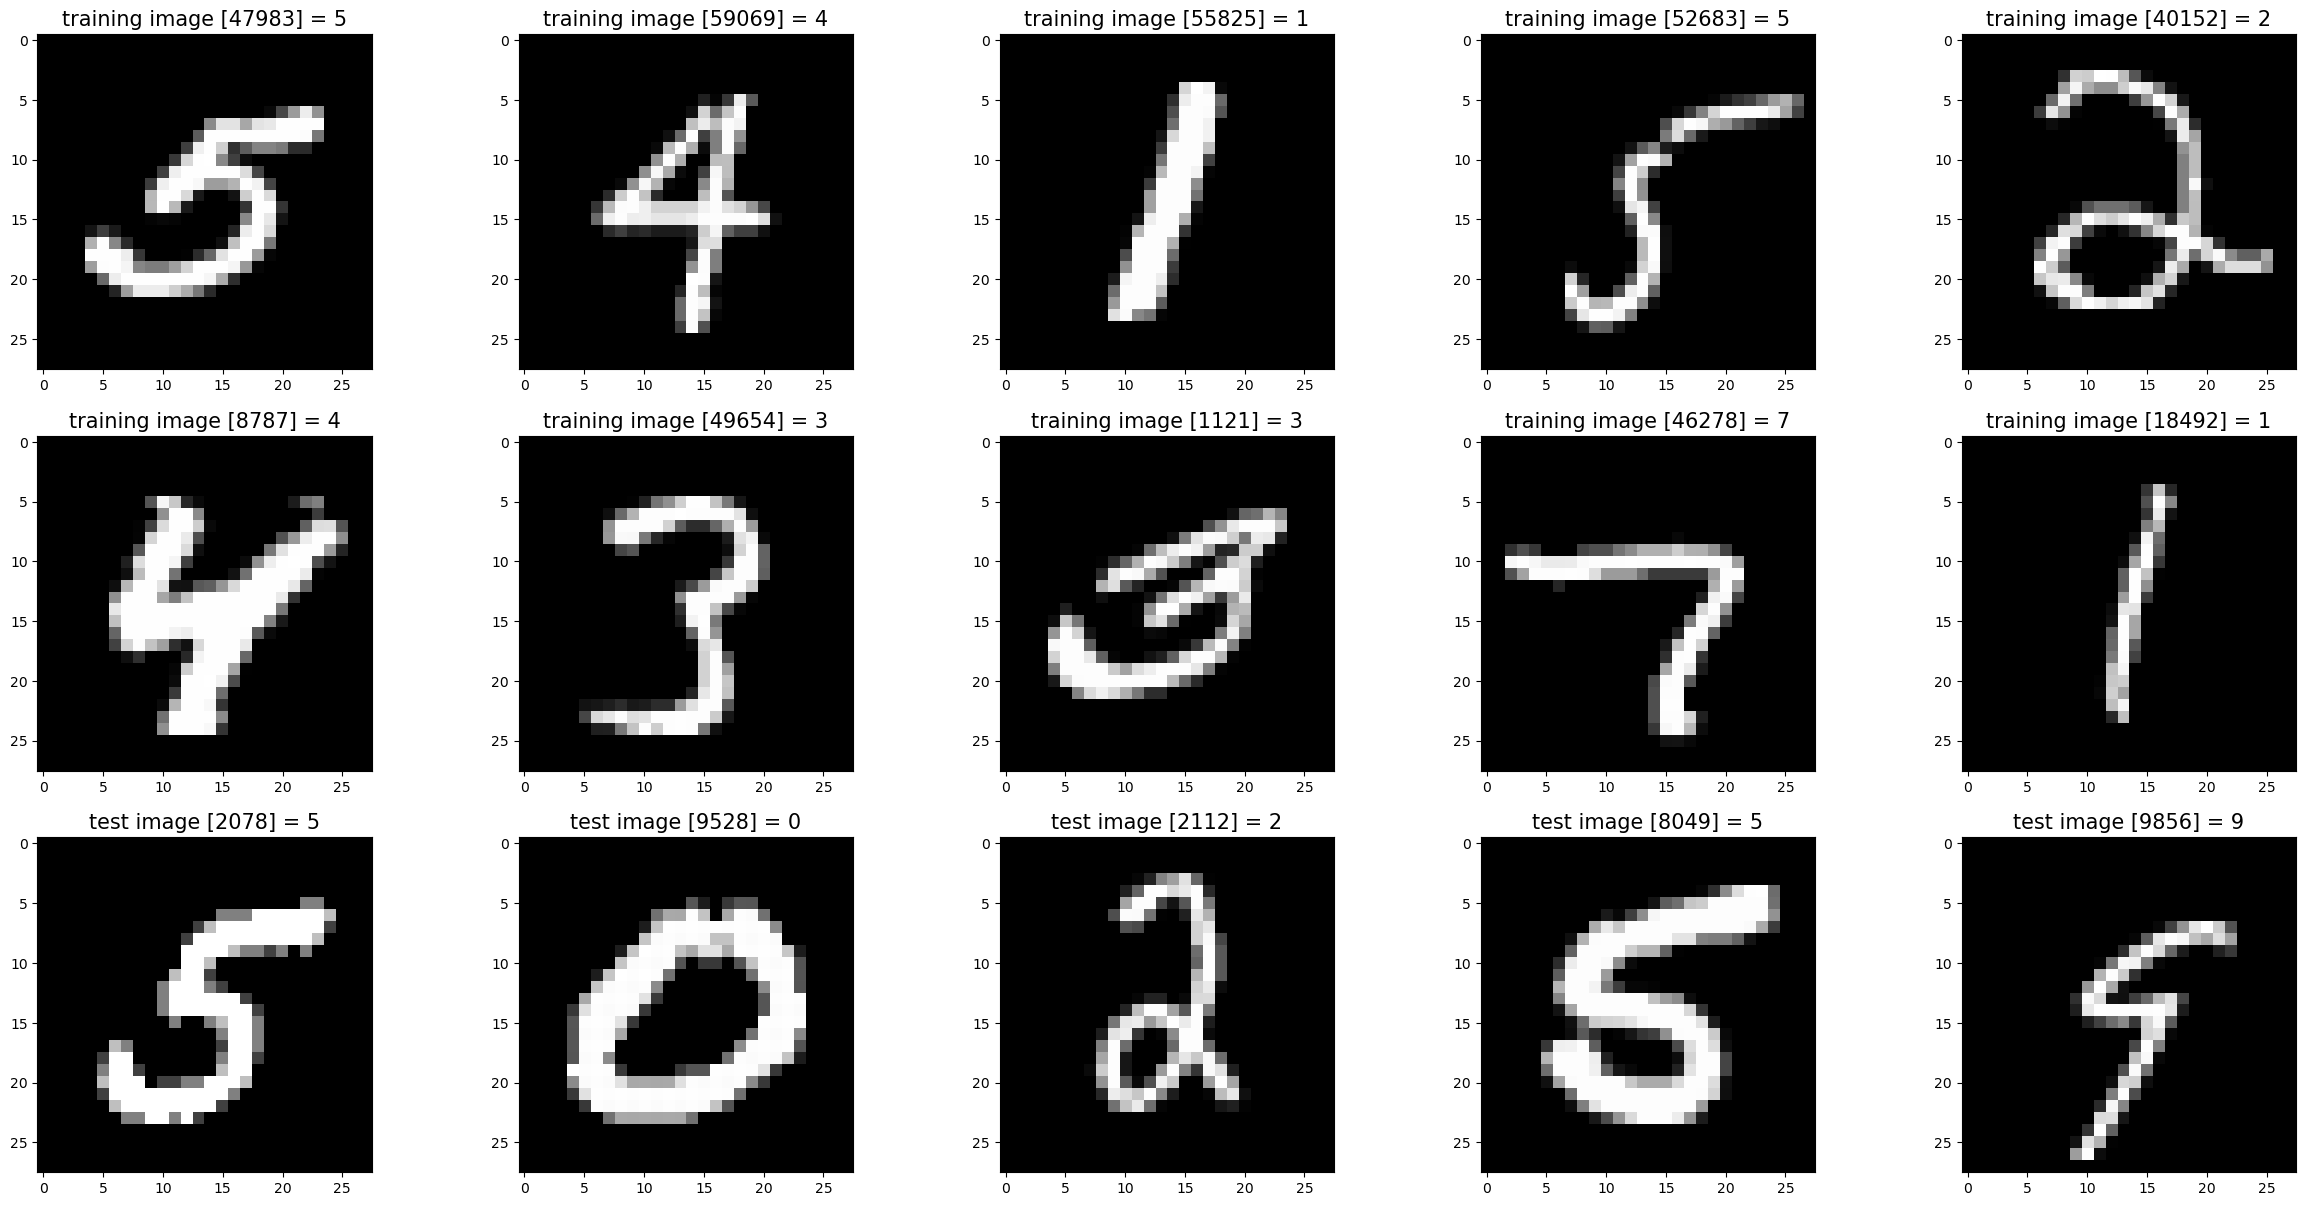

In [3]:
# other than inputting your paths, you can largely ignore this too unless relevant later
input_path = 'data/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Show some random training and test images 
import random
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

Okay, so the main two parts of the data that you feed into a supervised model is `X`, the data itself, and `y`, the labels to the data (i.e. classes). Here the labels are just the true numbers that these images represent and the data are the list of images. This data is split into two parts: training data and test data. Training data is the data you use to update your model parameters (i.e. "fit" or "train" to), and the test data is a random sampling of data that you set aside completely to test the validity of your model and ensure that you don't overfit. Check the shape structure of the `X_train`, `X_test`, `y_train` and `y_test` arrays below. Note that the zeroth index of each corresponds to the datapoint that you access. You'll see that there is much more training data than test data. Since each data has one class, the labels are a 1D array. The `X` data often has at one or more extra dimensions. Here, since each datapoint is a image, the next two indices in `X` correspond to the location of the pixel in the image and the value is the brightness.

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


##### Preprocessing data

Typically, you have to "clean" your data, which just means to strategically remove inaccurate data. Typically, you might have some very noisy data or blank entries or something that you should remove. Of course, this is very data dependent and can often take a lot of time to figure out in a big dataset. Here, the data is already cleaned.

After this, the next thing you often might choose to do is normalize your data to all have roughly the same range. This is allows models to treat each datapoint with roughly similar weighting and to avoid large ranges of numbers in your model that can runaway and cause accuracy problems. Generally models perform better when normalized, but remember that when you normalize your data, you typically lose information about the relative total of the data, which might be relevant for your situation (not here).

We will just linearly scale the data so that it is between 0 and 1.

In [5]:
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

##### Creating the model: Dense network

There are many ML models you can use, here we will start with a dense neural network (also called multi-layer perceptron or MLP).

The first thing we do is to split the training data further into some validation data that we can use to evaluate the network and update its "hyperparameters" (i.e. model architecture decision choices).

In [6]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [7]:
# create model
model = tf.keras.models.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), # three dense layers
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10),  # output layer
])

# compile model with chosen optimization scheme and loss function
optimizer = keras.optimizers.SGD(learning_rate=0.0015)
loss_func = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________


##### Running the model

We can now run the model we made and see how it performs by looking at the training and validation loss curves and the resulting confusion matrix when running on the test data. 

In [8]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
  81/1500 [>.............................] - ETA: 1s - loss: 2.2990 - accuracy: 0.1127

2025-06-10 18:32:40.781517: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1500/1500 [==============================] - 2s 2ms/step - loss: 1.6959 - accuracy: 0.6207 - val_loss: 0.9901 - val_accuracy: 0.7997
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7034 - accuracy: 0.8371 - val_loss: 0.5277 - val_accuracy: 0.8648
Epoch 3/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4696 - accuracy: 0.8773 - val_loss: 0.4084 - val_accuracy: 0.8909
Epoch 4/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3893 - accuracy: 0.8930 - val_loss: 0.3514 - val_accuracy: 0.9022
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3468 - accuracy: 0.9028 - val_loss: 0.3190 - val_accuracy: 0.9094
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3191 - accuracy: 0.9104 - val_loss: 0.2967 - val_accuracy: 0.9143
Epoch 7/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2985 - accuracy: 0.9149 - val_loss: 0.2779 - val_accuracy: 0.9208
Epo

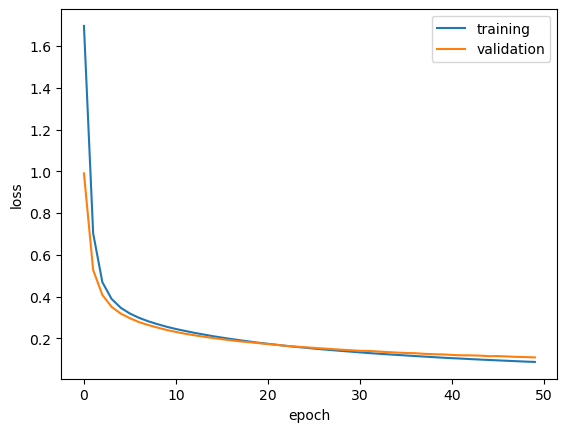

In [9]:
# loss curve
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

313/313 [==============================] - 0s 574us/step
Test accuracy: 96.5 %


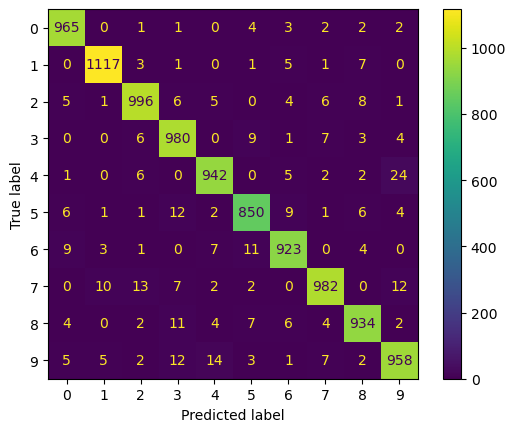

In [10]:
# run on test data to predict labels
y_pred = np.argmax(model.predict(X_test), axis=1)

# make confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
print("Test accuracy: %.1f %%" % (100*(sum(cm[i, i] for i in range(cm.shape[0])))/np.sum(cm)))
sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=list(range(10))).plot()

Try this data now on a convolution neural network (use something like `keras.layers.Conv2D` and `keras.layers.MaxPooling2D` layers to do so). Also, see how chaning the model architecture and other parameters like number of epochs, learning rate, etc. can effect performance. You can also try to use dropout layers (`keras.layers.Dropout`) to avoid overfitting if relevant. You can also try using other techniques from sklearn if you like such as decision trees, random forest, or support vector machines (SVMs) if you want. These are typically used on smaller datasets and usually not images (you'll likely have to flatten the data) and are more interpretable, but are also not as accurate.

In [11]:
# ...

##### Data augmentation

Look up data augmentation techniques (such as image rotation, translation, zoom, gaussian noise, etc.) and add ones you think are relevant to your network (it's fairly straightforward with keras layers). How does the performance change? What would this help achieve?

In [12]:
# ...

#### Another dataset for classification

When you're done with that, you can also try classification on the galaxy MNIST set, which contains images of galaxies. You can get the data at: 
  * http://astro.caltech.edu/~mjg/train_dataset.hdf5.gz
  * http://astro.caltech.edu/~mjg/test_dataset.hdf5.gz
  * http://astro.caltech.edu/~mjg/galaxy_mnist_train_catalog.parquet
  * http://astro.caltech.edu/~mjg/galaxy_mnist_test_catalog.parquet

You will have to load the parquet data using something like `pd.read_parquet` from the pandas library to get the labels and then you can uncompress the other files with the `gzip` libary and load the images from the resulting hdf5 files with the `h5py` libary. Remember to normalize again!

In [13]:
# ...

Of course, not all machine learning has to be on images. It can also be on any data in general. Images just tend to be a nice example, so we use those here. Often times, even if you have image data, it's actually even better to reduce the data to a handful of statistics to avoid noise and better understand your data (for example, in extragalactic astronomy, galaxy morphology statistics are commonly used like gini, M20, etc.), which allows you to use simpler machine learning technique and is in turn generally more interpretable.

#### Unsupervised Learning - PCA and K-means

What if we didn't have labels? How could we find out the numbers? For that we use unsupervised learning techniques. 

Our first step will be to use PCA to reduce the dimensionality of the dataset to 2D. 

In [14]:
pca = sklearn.decomposition.PCA(n_components=2)

X_flat = X_train.reshape((X_train.shape[0],np.prod(X_train.shape[1:])))
X_pca = pca.fit_transform(X_flat)
pc1, pc2 = X_pca.T

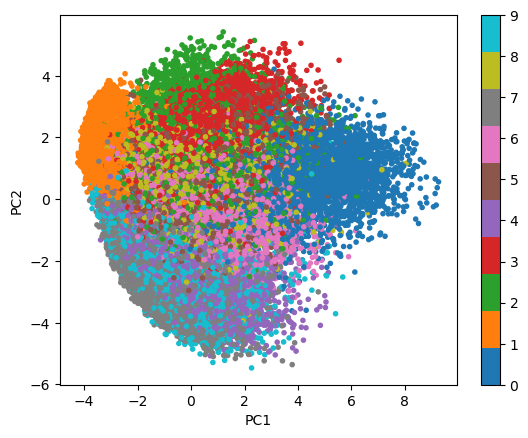

In [15]:
plt.scatter(pc1, pc2, c=y_train, cmap='tab10', marker='.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

It looks like we can sort of see a pattern when coloring by true label! What do these principal components (PC) correspond to? Do you understand why some of the numbers are where they are in the plot above? Hint: look at `pca.components_` and reshape them back to images.

In [16]:
# ...

Now, use k-means clustering (with k=10) on this data (without label information) to try to predict the classes without knowning the labels, and test your classifier with the test data. Go to higher `n_components` if you need. Try different feature scaling techniques (look into minmax vs standardization vs L2 normalization, etc.). Try other dimensionality reduction techniques like t-SNE or UMAP too if you want.

In [17]:
# ...

#### Anomaly detection

Another common used of machine learning is anomaly detection. Use isolation forest or k-nearest neighbours to try to find outliers in the data. Below is a quick implementation of isolation forest. See if you can improve on it and display a few outlier images. Can you tell why they are outliers? What about in the galaxy data?

In [18]:
from sklearn.ensemble import IsolationForest

X_seven = X_flat[y_train == 7]
clf = IsolationForest(random_state=0).fit(X_seven)
outlier_pred = clf.predict(X_seven)

print('{}/{} sevens are outliers'.format(np.sum(outlier_pred==-1), outlier_pred.shape[0]))

476/5037 sevens are outliers


In [19]:
# ...